# Exploring Convolutional Layers Through Data and Experiments

## Context and Motivation
En este trabajo, exploraremos cómo las decisiones arquitectónicas en redes neuronales convolucionales (CNN) afectan el aprendizaje, usando un dataset real y experimentos controlados.

## Dataset Selection and Justification
Para este ejercicio, selecciono el dataset **Fashion-MNIST** porque:
- Es un conjunto de imágenes de ropa (28x28 píxeles, escala de grises, 10 clases).
- Es ampliamente usado para experimentos con CNNs.
- Su tamaño permite cargarlo en memoria fácilmente.
- Presenta suficiente complejidad para observar diferencias entre arquitecturas.

## 1. Dataset Exploration (EDA)
Analizaremos el tamaño, distribución de clases, dimensiones de las imágenes y mostraremos ejemplos por clase.

In [1]:
# Importar librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
import seaborn as sns

In [17]:
# Semillas para reproducibilidad
import os, random
import tensorflow as tf
seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
print(f"Semillas fijadas con seed={seed}")

Semillas fijadas con seed=42


In [2]:
# Cargar el dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f'Tamaño de entrenamiento: {x_train.shape}, Tamaño de test: {x_test.shape}')

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 3us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Tamaño de entrenamiento: (60000, 28, 28), Tamaño de test: (10000, 28, 28)


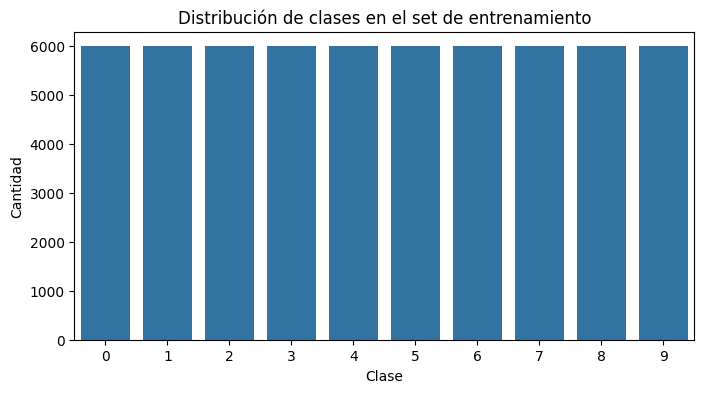

In [3]:
# Distribución de clases
plt.figure(figsize=(8,4))
sns.countplot(x=y_train)
plt.title('Distribución de clases en el set de entrenamiento')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.show()

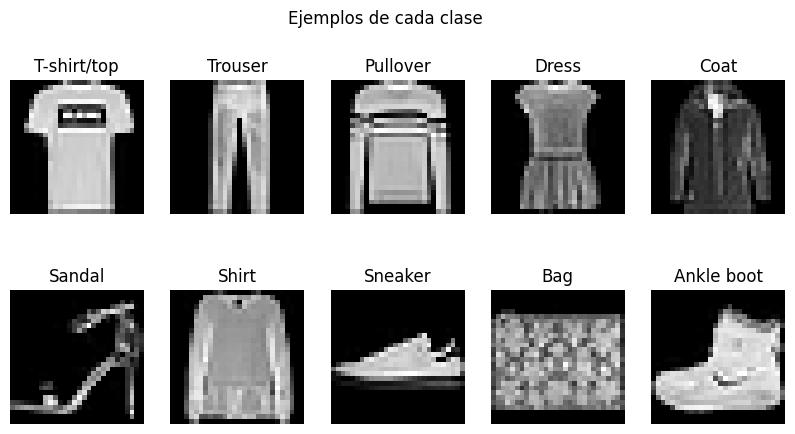

In [4]:
# Mostrar ejemplos por clase
plt.figure(figsize=(10,5))
for i in range(10):
    idx = np.where(y_train == i)[0][0]
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[idx], cmap='gray')
    plt.title(class_names[i])
    plt.axis('off')
plt.suptitle('Ejemplos de cada clase')
plt.show()

### Preprocesamiento
- Normalizaremos los valores de píxeles a [0,1].
- No es necesario redimensionar, ya que todas las imágenes son 28x28.

In [5]:
# Normalización
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

## 2. Baseline Model (Non-Convolutional)
Implementaremos una red neuronal simple solo con capas densas (fully connected) para establecer un punto de referencia.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# One-hot encoding de las etiquetas
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# Definir el modelo baseline
baseline_model = Sequential([
    Flatten(input_shape=(28,28)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

baseline_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

baseline_model.summary()

C:\Users\allan\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Entrenar el modelo baseline
history_baseline = baseline_model.fit(
    x_train, y_train_cat,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    verbose=2
)

Epoch 1/10
375/375 - 4s - 11ms/step - accuracy: 0.7810 - loss: 0.6304 - val_accuracy: 0.8394 - val_loss: 0.4528
Epoch 2/10
375/375 - 2s - 5ms/step - accuracy: 0.8450 - loss: 0.4396 - val_accuracy: 0.8605 - val_loss: 0.3938
Epoch 3/10
375/375 - 2s - 5ms/step - accuracy: 0.8571 - loss: 0.3970 - val_accuracy: 0.8694 - val_loss: 0.3712
Epoch 4/10
375/375 - 2s - 5ms/step - accuracy: 0.8676 - loss: 0.3683 - val_accuracy: 0.8727 - val_loss: 0.3578
Epoch 5/10
375/375 - 2s - 5ms/step - accuracy: 0.8714 - loss: 0.3501 - val_accuracy: 0.8777 - val_loss: 0.3433
Epoch 6/10
375/375 - 2s - 5ms/step - accuracy: 0.8788 - loss: 0.3349 - val_accuracy: 0.8769 - val_loss: 0.3388
Epoch 7/10
375/375 - 2s - 5ms/step - accuracy: 0.8821 - loss: 0.3227 - val_accuracy: 0.8786 - val_loss: 0.3347
Epoch 8/10
375/375 - 2s - 5ms/step - accuracy: 0.8843 - loss: 0.3143 - val_accuracy: 0.8824 - val_loss: 0.3229
Epoch 9/10
375/375 - 2s - 5ms/step - accuracy: 0.8895 - loss: 0.3038 - val_accuracy: 0.8827 - val_loss: 0.3219


In [8]:
# Evaluar el modelo baseline
loss, acc = baseline_model.evaluate(x_test, y_test_cat, verbose=0)
print(f"Test accuracy: {acc:.4f} | Test loss: {loss:.4f}")

Test accuracy: 0.8740 | Test loss: 0.3493


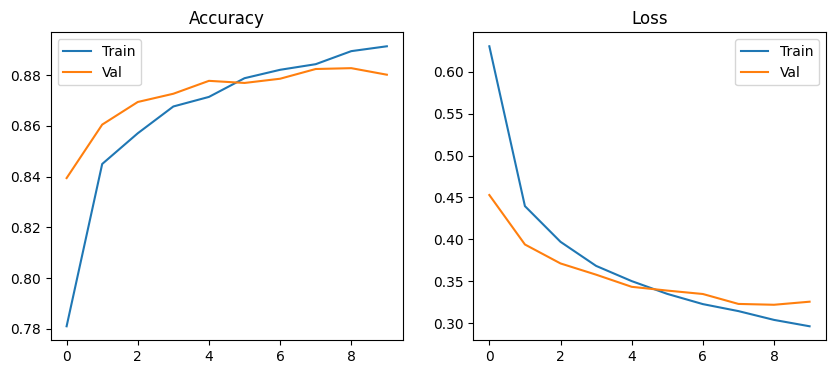

In [9]:
# Graficar el desempeño del modelo baseline
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_baseline.history['accuracy'], label='Train')
plt.plot(history_baseline.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_baseline.history['loss'], label='Train')
plt.plot(history_baseline.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.show()

### Observed Limitations
- El modelo baseline no captura la estructura espacial de las imágenes.
- Puede tener menor capacidad de generalización en comparación con una CNN.
- Sirve como referencia para comparar mejoras con arquitecturas convolucionales.

## 3. Convolutional Architecture Design
Diseñaremos una CNN simple y justificaremos cada decisión arquitectónica.

### Arquitectura propuesta
- 2 capas convolucionales (filtros 3x3, 32 y 64 filtros respectivamente)
- Stride 1, padding 'same' para preservar dimensiones
- Activación ReLU
- MaxPooling después de cada convolución
- Capa densa final para clasificación

Justificación: Esta arquitectura es suficientemente simple para observar el efecto de las capas convolucionales, pero suficientemente expresiva para mejorar sobre el baseline.

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Sequential

# Preparar datos para CNN (agregar canal)
x_train_cnn = np.expand_dims(x_train, -1)
x_test_cnn = np.expand_dims(x_test, -1)

cnn_model = Sequential([
    Input(shape=(28,28,1)),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,234 (860.29 KB)

 Trainable params: 220,234 (860.29 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Entrenar la CNN
history_cnn = cnn_model.fit(
    x_train_cnn, y_train_cat,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    verbose=2
)

Epoch 1/10
375/375 - 15s - 39ms/step - accuracy: 0.7562 - loss: 0.6846 - val_accuracy: 0.8540 - val_loss: 0.4007
Epoch 2/10
375/375 - 12s - 32ms/step - accuracy: 0.8518 - loss: 0.4190 - val_accuracy: 0.8706 - val_loss: 0.3451
Epoch 3/10
375/375 - 12s - 33ms/step - accuracy: 0.8716 - loss: 0.3607 - val_accuracy: 0.8859 - val_loss: 0.3126
Epoch 4/10
375/375 - 12s - 31ms/step - accuracy: 0.8834 - loss: 0.3289 - val_accuracy: 0.8963 - val_loss: 0.2839
Epoch 5/10
375/375 - 12s - 32ms/step - accuracy: 0.8920 - loss: 0.2991 - val_accuracy: 0.9025 - val_loss: 0.2748
Epoch 6/10
375/375 - 12s - 32ms/step - accuracy: 0.8971 - loss: 0.2882 - val_accuracy: 0.9051 - val_loss: 0.2616
Epoch 7/10
375/375 - 12s - 31ms/step - accuracy: 0.9024 - loss: 0.2679 - val_accuracy: 0.9014 - val_loss: 0.2616
Epoch 8/10
375/375 - 12s - 32ms/step - accuracy: 0.9084 - loss: 0.2561 - val_accuracy: 0.9122 - val_loss: 0.2422
Epoch 9/10
375/375 - 12s - 32ms/step - accuracy: 0.9119 - loss: 0.2436 - val_accuracy: 0.9078 - 

In [12]:
# Evaluar la CNN
loss_cnn, acc_cnn = cnn_model.evaluate(x_test_cnn, y_test_cat, verbose=0)
print(f"Test accuracy: {acc_cnn:.4f} | Test loss: {loss_cnn:.4f}")

Test accuracy: 0.9091 | Test loss: 0.2547


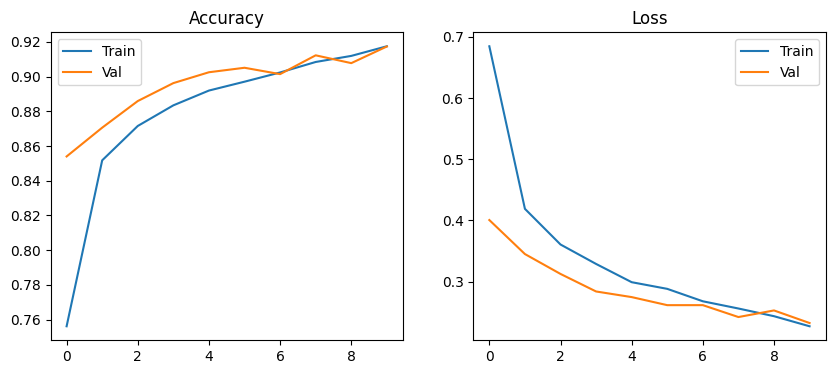

In [13]:
# Graficar desempeño de la CNN
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_cnn.history['accuracy'], label='Train')
plt.plot(history_cnn.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_cnn.history['loss'], label='Train')
plt.plot(history_cnn.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.show()

## 4. Controlled Experiments on the Convolutional Layer
Exploraremos el efecto del tamaño del kernel (3x3 vs 5x5) manteniendo todo lo demás fijo.

In [14]:
# Modelo con kernel 5x5
cnn_model_5x5 = Sequential([
    Input(shape=(28,28,1)),
    Conv2D(32, (5,5), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Conv2D(64, (5,5), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

cnn_model_5x5.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

history_cnn_5x5 = cnn_model_5x5.fit(
    x_train_cnn, y_train_cat,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    verbose=2
)

loss_5x5, acc_5x5 = cnn_model_5x5.evaluate(x_test_cnn, y_test_cat, verbose=0)
print(f"Test accuracy (5x5): {acc_5x5:.4f} | Test loss: {loss_5x5:.4f}")

Epoch 1/10
375/375 - 14s - 38ms/step - accuracy: 0.7623 - loss: 0.6621 - val_accuracy: 0.8591 - val_loss: 0.3846
Epoch 2/10
375/375 - 14s - 39ms/step - accuracy: 0.8553 - loss: 0.4123 - val_accuracy: 0.8825 - val_loss: 0.3305
Epoch 3/10
375/375 - 12s - 33ms/step - accuracy: 0.8771 - loss: 0.3508 - val_accuracy: 0.8925 - val_loss: 0.3044
Epoch 4/10
375/375 - 12s - 33ms/step - accuracy: 0.8870 - loss: 0.3163 - val_accuracy: 0.8985 - val_loss: 0.2747
Epoch 5/10
375/375 - 13s - 34ms/step - accuracy: 0.8979 - loss: 0.2910 - val_accuracy: 0.9020 - val_loss: 0.2634
Epoch 6/10
375/375 - 12s - 33ms/step - accuracy: 0.9032 - loss: 0.2691 - val_accuracy: 0.9080 - val_loss: 0.2495
Epoch 7/10
375/375 - 13s - 35ms/step - accuracy: 0.9088 - loss: 0.2550 - val_accuracy: 0.9037 - val_loss: 0.2561
Epoch 8/10
375/375 - 13s - 35ms/step - accuracy: 0.9126 - loss: 0.2396 - val_accuracy: 0.9103 - val_loss: 0.2423
Epoch 9/10
375/375 - 13s - 35ms/step - accuracy: 0.9193 - loss: 0.2247 - val_accuracy: 0.9166 - 

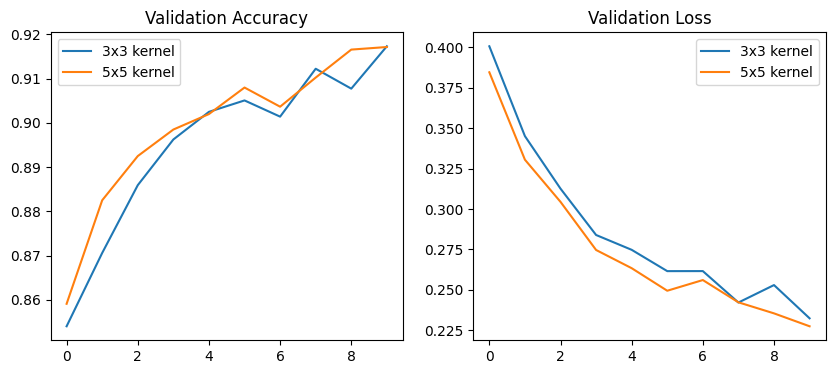

In [15]:
# Comparar desempeño de 3x3 vs 5x5
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_cnn.history['val_accuracy'], label='3x3 kernel')
plt.plot(history_cnn_5x5.history['val_accuracy'], label='5x5 kernel')
plt.title('Validation Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_cnn.history['val_loss'], label='3x3 kernel')
plt.plot(history_cnn_5x5.history['val_loss'], label='5x5 kernel')
plt.title('Validation Loss')
plt.legend()
plt.show()

## 5. Interpretation and Architectural Reasoning
Responde en tus propias palabras (guía inicial):

- ¿Por qué las capas convolucionales superaron (o no) al baseline?
  - Explotan la estructura espacial e introducen compartición de pesos y localidad, reduciendo parámetros y mejorando generalización.

- ¿Qué sesgo inductivo introduce la convolución?
  - Localidad, compartición de pesos e invariancia a traslación.

- ¿Cuándo no usar convoluciones?
  - Datos tabulares sin relación posicional, secuencias con dependencias no locales (preferir transformadores/RNNs), grafos (preferir GNNs).

## 6. Deployment in SageMaker
Entrenaremos y desplegaremos el modelo en un endpoint de SageMaker usando el SDK de SageMaker. Necesitarás:
- Credenciales AWS configuradas.
- Un `role` de IAM con permisos para SageMaker y S3.
- Un bucket S3 en tu región.

Usaremos un script de entrenamiento (`train.py`) empaquetado por el SDK.

In [16]:
# Guardar artefactos: modelos y métricas
import os, json
from datetime import datetime

# Crear carpetas
os.makedirs('artifacts', exist_ok=True)
os.makedirs('models', exist_ok=True)

stamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Guardar historiales si existen
artifacts = {}
if 'history_baseline' in globals() and hasattr(history_baseline, 'history'):
    artifacts['baseline'] = history_baseline.history
    # Guardar modelo baseline
    try:
        baseline_model.save(f'models/baseline_{stamp}.keras')
    except Exception as e:
        print('No se pudo guardar baseline_model:', e)

if 'history_cnn' in globals() and hasattr(history_cnn, 'history'):
    artifacts['cnn_3x3'] = history_cnn.history
    try:
        cnn_model.save(f'models/cnn_3x3_{stamp}.keras')
    except Exception as e:
        print('No se pudo guardar cnn_model:', e)

if 'history_cnn_5x5' in globals() and hasattr(history_cnn_5x5, 'history'):
    artifacts['cnn_5x5'] = history_cnn_5x5.history
    try:
        cnn_model_5x5.save(f'models/cnn_5x5_{stamp}.keras')
    except Exception as e:
        print('No se pudo guardar cnn_model_5x5:', e)

# Guardar métricas agregadas
summary_metrics = {
    'test_accuracy': {
        'baseline': float(acc) if 'acc' in globals() else None,
        'cnn_3x3': float(acc_cnn) if 'acc_cnn' in globals() else None,
        'cnn_5x5': float(acc_5x5) if 'acc_5x5' in globals() else None,
    },
    'test_loss': {
        'baseline': float(loss) if 'loss' in globals() else None,
        'cnn_3x3': float(loss_cnn) if 'loss_cnn' in globals() else None,
        'cnn_5x5': float(loss_5x5) if 'loss_5x5' in globals() else None,
    }
}

with open(f'artifacts/metrics_{stamp}.json', 'w', encoding='utf-8') as f:
    json.dump({'histories': artifacts, 'summary': summary_metrics}, f, ensure_ascii=False, indent=2)

print('Artefactos guardados en carpeta artifacts y models.')

Artefactos guardados en carpeta artifacts y models.
